In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

from torch import Tensor

In [3]:
from transformers import BertTokenizer

m:\disco m\python\pythonprojects\pytorch\env_pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
np.random.seed(42)

# [X] Tokenizer

In [5]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# Tokenize a sentence
sentence = "i am luiz"
tokens = tokenizer.tokenize(sentence)
# print the result
tokens

['i', 'am', 'lu', '##iz']

In [7]:
# Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
# print the results
token_ids

[1045, 2572, 11320, 10993]

In [8]:
# Print the results
print("Original sentence:", sentence)
print("Tokenized tokens:", tokens)
print("Token IDs:", token_ids)

Original sentence: i am luiz
Tokenized tokens: ['i', 'am', 'lu', '##iz']
Token IDs: [1045, 2572, 11320, 10993]


In [9]:
# Encode a sentence (add special tokens, tokenize, and convert to IDs)
input_ids = tokenizer.encode(sentence, add_special_tokens=True)
print("Input IDs:", input_ids)

Input IDs: [101, 1045, 2572, 11320, 10993, 102]


# [X] Word Embedding

In [10]:
input_ids = torch.tensor(input_ids)

In [11]:
VOCAB_SIZE = torch.max(input_ids) + 1  # you need to do this (think a little about why this works)
D_MODEL = 2

In [12]:
# Create embedding layer
embedding_layer = nn.Embedding(VOCAB_SIZE, D_MODEL, _freeze=True)
embedding_layer

Embedding(11321, 2)

In [13]:
input_ids = torch.tensor(input_ids, dtype=torch.int)

C:\Users\luiz_\AppData\Local\Temp\ipykernel_11140\3777662116.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.int)


In [14]:
embedded_sequence = embedding_layer(input_ids)
# Now we have the representation of our sentence "i am luiz" in the following vector
embedded_sequence

tensor([[-0.3643,  0.0756],
        [-0.1727,  1.1920],
        [ 0.0716, -0.7074],
        [-1.1366,  0.9420],
        [ 1.9512,  0.0990],
        [ 0.3223, -0.0165]])

## Viewing in Space

In [15]:
vector = np.array(embedded_sequence)

In [16]:
token_text = ['[CLS]'] + tokens + ['[SEP]']
token_text

['[CLS]', 'i', 'am', 'lu', '##iz', '[SEP]']

In [17]:
token_texts = np.array(token_text).reshape(-1,1)

In [18]:
# data = np.hstack((vector, token_text))

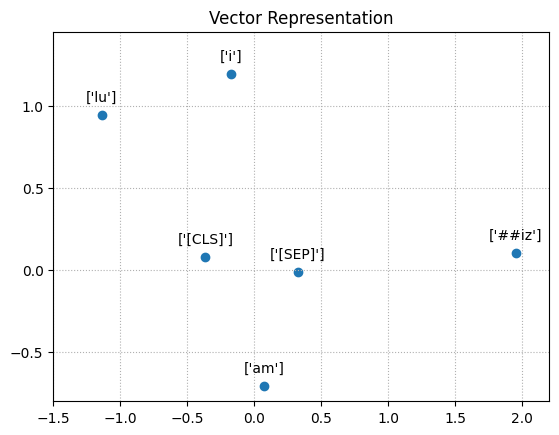

In [29]:
fig, ax = plt.subplots()
ax.set_title('Vector Representation')
ax.scatter(x=embedded_sequence[:, 0], y=embedded_sequence[:, 1])
ax.grid(True, linestyle=':')
# Adicionar rótulos a cada ponto
for label, x, y in zip(token_texts, embedded_sequence[:, 0], embedded_sequence[:, 1]):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
ax.set_ylim(top=1.45)
ax.set_xlim(left=-1.5, right=2.2)
plt.show()

# [X] Positional Embedding

In [30]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [31]:
positional_encoding_layer = PositionalEncoding(d_model=2)
positional_embedded = positional_encoding_layer(embedded_sequence)

In [32]:
positional_embedded = positional_embedded.detach()[0]

In [33]:
print(f'Only with Word Embedding: \n {embedded_sequence}\n')
print(f'Adding Positional Embedding: \n {positional_embedded}')

Only with Word Embedding: 
 tensor([[-0.3643,  0.0756],
        [-0.1727,  1.1920],
        [ 0.0716, -0.7074],
        [-1.1366,  0.9420],
        [ 1.9512,  0.0990],
        [ 0.3223, -0.0165]])

Adding Positional Embedding: 
 tensor([[-0.3643,  1.0756],
        [-0.1727,  2.1920],
        [ 0.0716,  0.2926],
        [-1.1366,  1.9420],
        [ 1.9512,  1.0990],
        [ 0.3223,  0.9835]])


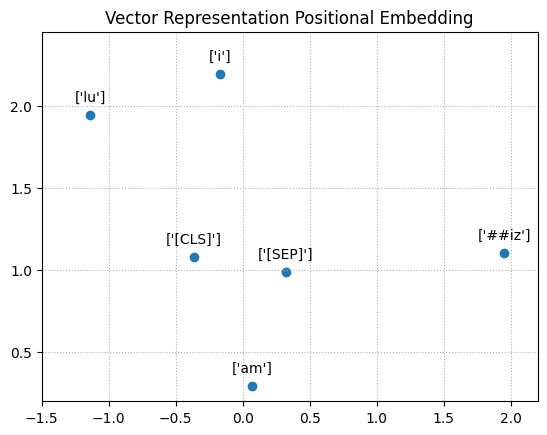

In [38]:
fig, ax = plt.subplots()
ax.set_title('Vector Representation Positional Embedding')
ax.scatter(x=positional_embedded[:, 0], y=positional_embedded[:, 1])
ax.grid(True, linestyle=':')
# Adicionar rótulos a cada ponto
for label, x, y in zip(token_texts, positional_embedded[:, 0], positional_embedded[:, 1]):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
ax.set_ylim(top=2.45)
ax.set_xlim(left=-1.5, right=2.2)
plt.show()

In [170]:
# It seems like nothing has changed, but yes, we are adding 0 in the first column and 1 in the second
positional_encoding_layer.pe

tensor([[[0., 1.]]])

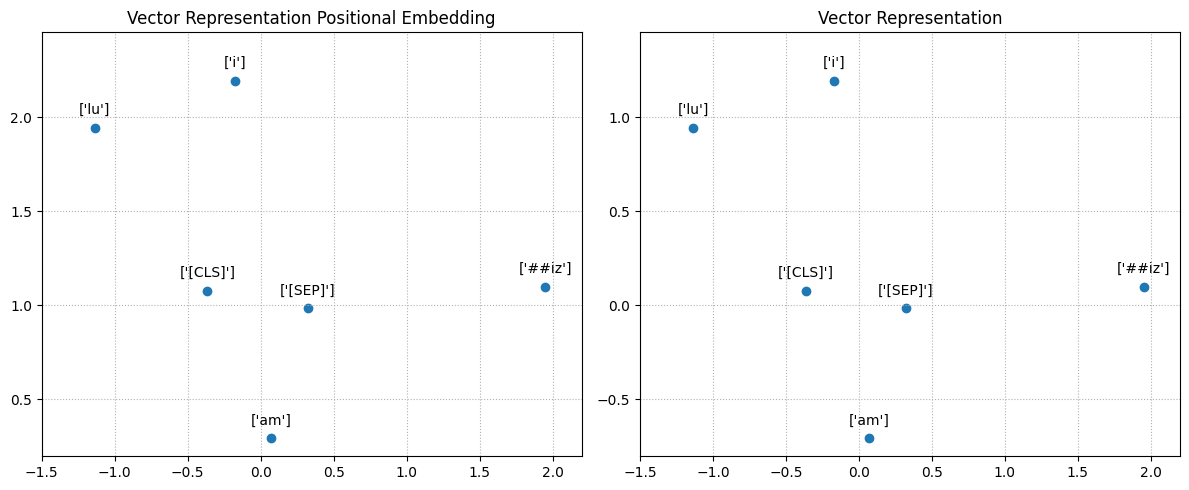

In [40]:
# Notice the y scale
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('Vector Representation Positional Embedding')
axs[0].scatter(x=positional_embedded[:, 0], y=positional_embedded[:, 1])
axs[0].grid(True, linestyle=':')
for label, x, y in zip(token_texts, positional_embedded[:, 0], positional_embedded[:, 1]):
    axs[0].annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
axs[0].set_ylim(top=2.45)
axs[0].set_xlim(left=-1.5, right=2.2)



axs[1].set_title('Vector Representation')
axs[1].scatter(x=embedded_sequence[:, 0], y=embedded_sequence[:, 1])
axs[1].grid(True, linestyle=':')
for label, x, y in zip(token_texts, embedded_sequence[:, 0], embedded_sequence[:, 1]):
    axs[1].annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
axs[1].set_ylim(top=1.45)
axs[1].set_xlim(left=-1.5, right=2.2)

plt.tight_layout()

plt.show()

# [X] Attention 

You can use:   
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)  
However, we will do the Attention layer ourselves

In [194]:
attention_layer = nn.MultiheadAttention(
    embed_dim=D_MODEL, num_heads=2, 
)

In [195]:
query = positional_embedded
key = positional_embedded
value = positional_embedded

In [197]:
attention_embedded, _ = attention_layer(query, key, value)

In [198]:
attention_embedded

tensor([[-0.3189, -0.0183],
        [-0.3325, -0.0494],
        [-0.2846,  0.0043],
        [-0.3500, -0.0206],
        [-0.3163, -0.0790],
        [-0.3262, -0.0198]], grad_fn=<SqueezeBackward1>)

In [199]:
_

tensor([[0.1697, 0.1507, 0.2204, 0.1367, 0.1612, 0.1613],
        [0.1738, 0.1518, 0.1971, 0.1738, 0.1312, 0.1723],
        [0.1616, 0.1586, 0.1966, 0.1285, 0.2010, 0.1536],
        [0.1698, 0.1357, 0.2730, 0.1255, 0.1390, 0.1570],
        [0.1663, 0.1611, 0.1333, 0.2358, 0.1252, 0.1783],
        [0.1704, 0.1476, 0.2303, 0.1352, 0.1554, 0.1611]],
       grad_fn=<SqueezeBackward1>)

In [201]:
attention_embedded[:, 0]

tensor([-0.3189, -0.3325, -0.2846, -0.3500, -0.3163, -0.3262],
       grad_fn=<SelectBackward0>)

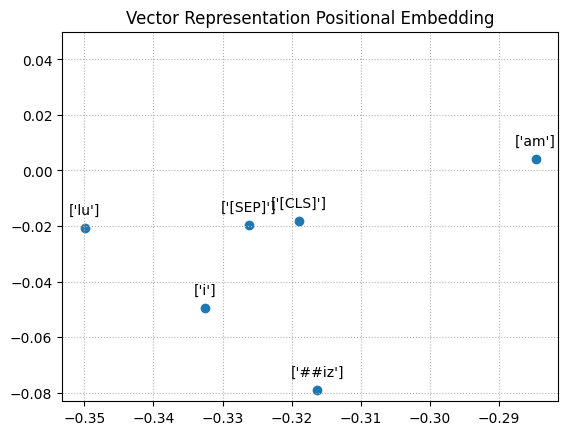

In [207]:
fig, ax = plt.subplots()
ax.set_title('Vector Representation Positional Embedding')
ax.scatter(x=attention_embedded[:, 0].detach().numpy(), y=attention_embedded[:, 1].detach().numpy())
ax.grid(True, linestyle=':')
# Adicionar rótulos a cada ponto
for label, x, y in zip(token_texts, attention_embedded[:, 0].detach().numpy(), attention_embedded[:, 1].detach().numpy()):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
ax.set_ylim(top=0.05)
plt.show()